In [6]:
!pip install tifffile

In [4]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import nrrd

In [5]:
# Define the folder containing the images
current_directory = os.getcwd()
print(os.getcwd())

C:\Users\prana\Desktop\CV_Project\Microscopy_Seg_CVProjectFall23


In [6]:
directory = current_directory + "\\tif\\"

Training Data:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 22, 244



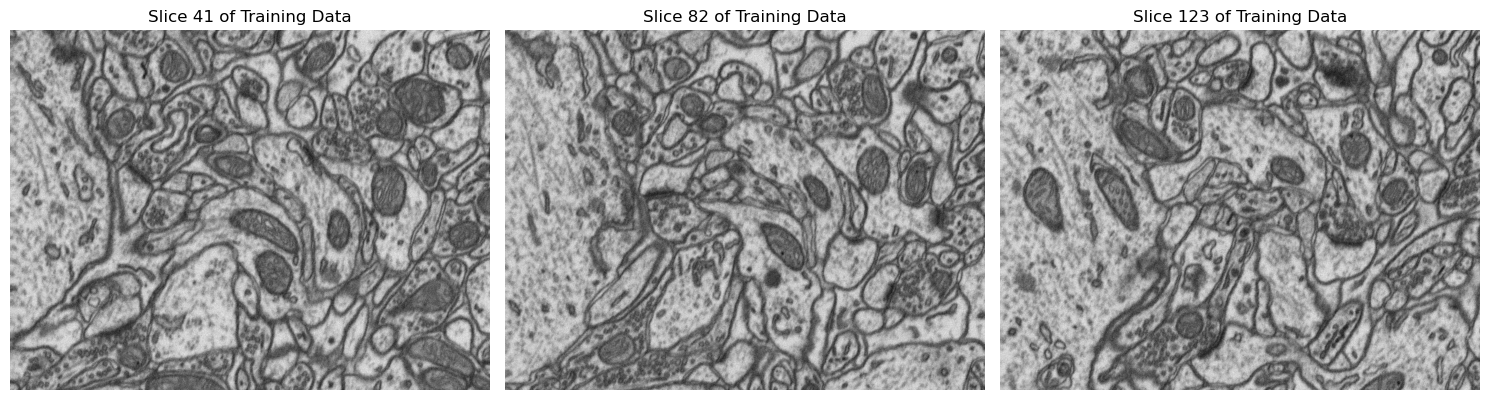

Training Groundtruth:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 0, 255



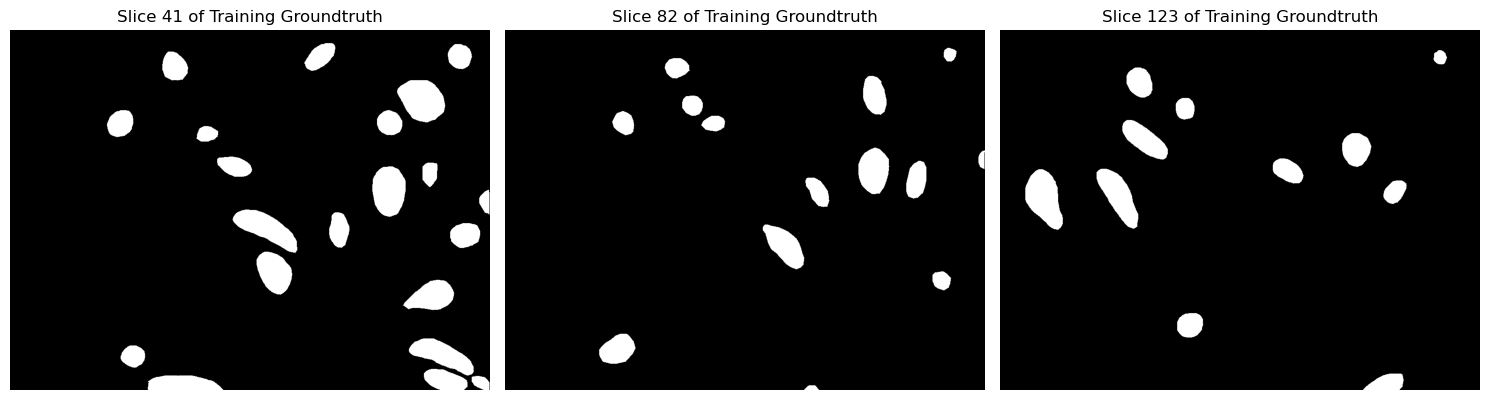

Testing Data:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 2, 255



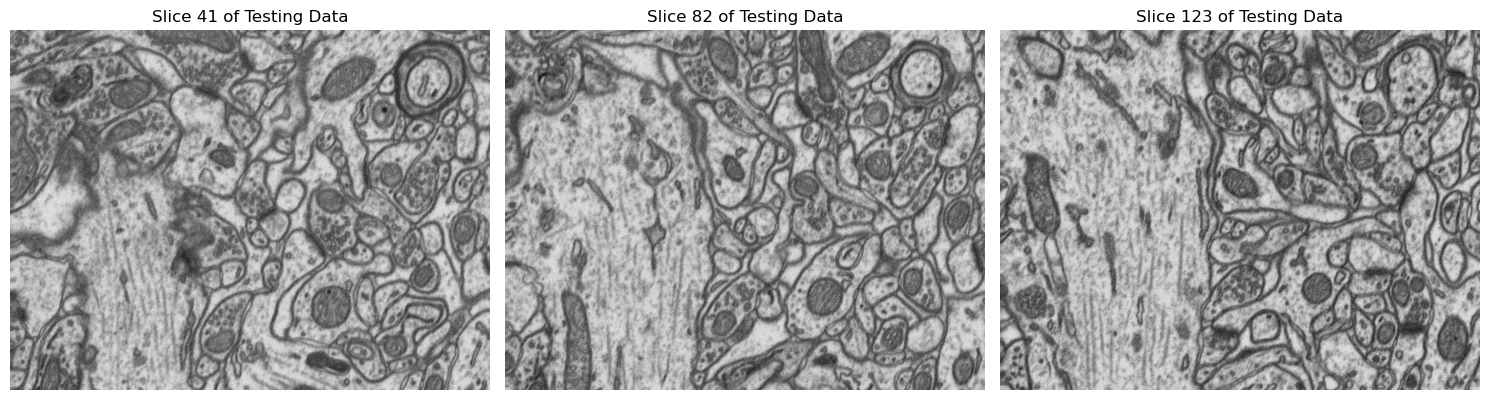

Testing Groundtruth:
Data shape: (165, 768, 1024)
Data type: uint8
Min and max values: 0, 255



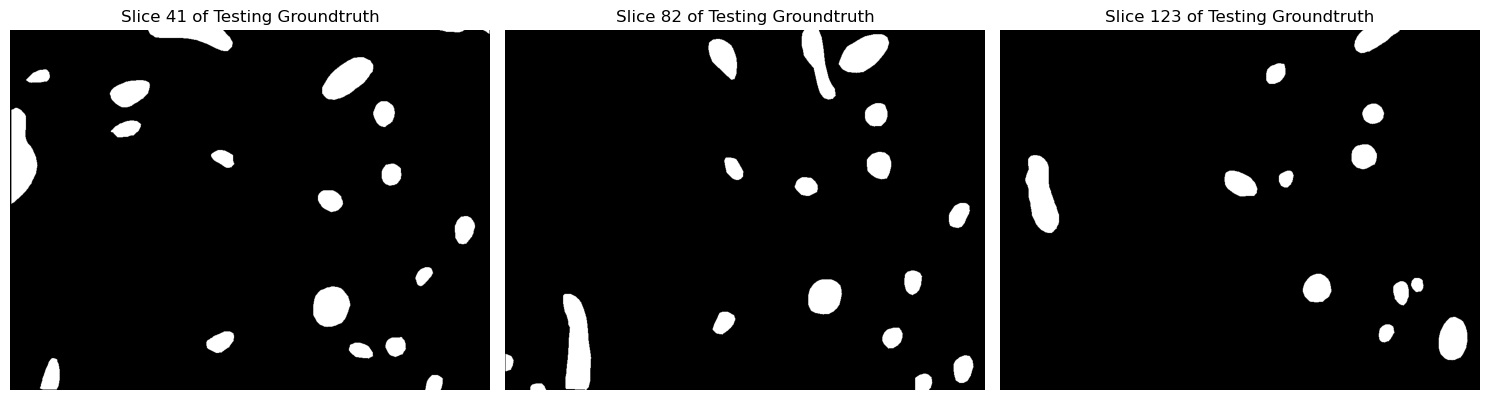

In [4]:
# Define the folder containing the images
current_directory = os.getcwd()
directory = current_directory + "\\tif\\" # replace with the path to your directory

# Load the files
train_data = tiff.imread(os.path.join(directory, 'training.tif'))
train_groundtruth = tiff.imread(os.path.join(directory, 'training_groundtruth.tif'))
test_data = tiff.imread(os.path.join(directory, 'testing.tif'))
test_groundtruth = tiff.imread(os.path.join(directory, 'testing_groundtruth.tif'))

datasets = {
    "Training Data": train_data,
    "Training Groundtruth": train_groundtruth,
    "Testing Data": test_data,
    "Testing Groundtruth": test_groundtruth
}

# Exploring and visualizing the datasets
for name, data in datasets.items():
    print(f"{name}:")
    print(f"Data shape: {data.shape}")
    print(f"Data type: {data.dtype}")
    print(f"Min and max values: {data.min()}, {data.max()}\n")

    # Visualize some slices
    num_slices = data.shape[0]
    sample_slices = [num_slices//4, num_slices//2, 3*num_slices//4]

    fig, axes = plt.subplots(1, len(sample_slices), figsize=(15, 5))
    for idx, slice_idx in enumerate(sample_slices):
        axes[idx].imshow(data[slice_idx, ...], cmap='gray')
        axes[idx].set_title(f'Slice {slice_idx} of {name}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [5]:


# Load the files
train_data = tiff.imread(os.path.join(directory, 'training.tif'))
train_groundtruth = tiff.imread(os.path.join(directory, 'training_groundtruth.tif'))
test_data = tiff.imread(os.path.join(directory, 'testing.tif'))
test_groundtruth = tiff.imread(os.path.join(directory, 'testing_groundtruth.tif'))

# Resize function
def resize_data(data):
    resized_data = np.zeros((165, 500, 500), dtype=np.uint8)
    for i in range(165):
        resized_data[i] = resize(data[i], (500, 500), preserve_range=True).astype(np.uint8)
    return resized_data

# Resize the data
train_data_resized = resize_data(train_data)
train_groundtruth_resized = resize_data(train_groundtruth)
test_data_resized = resize_data(test_data)
test_groundtruth_resized = resize_data(test_groundtruth)



NameError: name 'resize' is not defined

In [7]:
# Create directories to store resized images
resized_train_data_dir = os.path.join(directory, 'reTrain500')
resized_train_gt_dir = os.path.join(directory, 'reTrainGT500')
resized_test_data_dir = os.path.join(directory, 'reTest500')
resized_test_gt_dir = os.path.join(directory, 'reTestGT500')

os.makedirs(resized_train_data_dir, exist_ok=True)
os.makedirs(resized_train_gt_dir, exist_ok=True)
os.makedirs(resized_test_data_dir, exist_ok=True)
os.makedirs(resized_test_gt_dir, exist_ok=True)

# Save the resized data
for i in range(165):
    tiff.imsave(os.path.join(resized_train_data_dir, f'train_{i}.tif'), train_data_resized[i])
    tiff.imsave(os.path.join(resized_train_gt_dir, f'train_gt_{i}.tif'), train_groundtruth_resized[i])
    tiff.imsave(os.path.join(resized_test_data_dir, f'test_{i}.tif'), test_data_resized[i])
    tiff.imsave(os.path.join(resized_test_gt_dir, f'test_gt_{i}.tif'), test_groundtruth_resized[i])


**LOAD DATA HERE**

In [7]:
# Load resized images from folders
def load_resized_data(data_dir, filename):
    data = np.zeros((165, 500, 500), dtype=np.uint8)
    for i in range(165):
        data[i] = tiff.imread(os.path.join(data_dir, f'{os.path.basename(filename)}_{i}.tif'))
    return data

print(directory)

resized_train_data = load_resized_data(directory + "reTrain500", "train")
resized_train_groundtruth = load_resized_data(directory + "reTrainGT500", "train_gt" )
resized_test_data = load_resized_data(directory + "reTest500", "test")
resized_test_groundtruth = load_resized_data(directory + "reTestGT500", "test_gt")


C:\Users\prana\Desktop\CV_Project\Microscopy_Seg_CVProjectFall23\tif\


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2DTranspose,ZeroPadding2D,Conv2D,Add,Dropout,Input,UpSampling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img,img_to_array,plot_model 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping,Callback

In [9]:
def decoder_block(input,skip_features, num_filters,conv_padding=False,zero_pad=False):

    x= Conv2DTranspose(num_filters, 2, activation = 'relu',strides=(2,2), kernel_initializer = 'he_normal')(input)

    if zero_pad == True:
      x=ZeroPadding2D((1,1))(x)
    
    if conv_padding ==True:
        x=Conv2D(num_filters, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(x)
    else:
        x=Conv2D(num_filters, 2, activation = 'relu', kernel_initializer = 'he_normal')(x)
    
    x = Add()([x, skip_features])
    return x

In [10]:
def Unet_VGG19(input_size,n_classes):
    """ Input """
    inp = Input(input_size)
    """ Pre-trained Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inp)
    """ Encoder """
    E0=vgg19.get_layer("block1_conv2").output
    E0=Conv2D(128, 3, activation = 'relu', padding='same')(E0)
    E0=Conv2D(64, 3, activation = 'relu', padding='same')(E0)
    
    
    
    
    E1=vgg19.get_layer("block1_pool").output
    E1=Conv2D(128, 3, activation = 'relu', padding='same')(E1)
    E1=Conv2D(64, 3, activation = 'relu', padding='same')(E1)
    
    
    E2=vgg19.get_layer("block2_pool").output
    E2=Conv2D(128, 3, activation = 'relu', padding='same')(E2)
    
    
    E3=vgg19.get_layer("block3_pool").output
    E3=Conv2D(512, 3, activation = 'relu', padding='same')(E3)
    E3=Conv2D(256, 3, activation = 'relu', padding='same')(E3)
    
    
    E4=vgg19.get_layer("block4_pool").output
    E4=Conv2D(1024, 3, activation = 'relu', padding='same')(E4)
    E4=Conv2D(512, 3, activation = 'relu', padding='same')(E4)
    
    
    """ Bridge """
    B1=vgg19.get_layer("block5_pool").output
    B1=Conv2D(1024, 3, activation = 'relu', padding='same')(B1)
    
    """ Decoder """
    D1=decoder_block(B1,E4,512,zero_pad=True)
    
    
    D2=decoder_block(D1,E3,256,conv_padding=True)

    D3=decoder_block(D2,E2,128,zero_pad=True)

    D4=decoder_block(D3,E1,64,conv_padding=True)
    
    D5=decoder_block(D4,E0,64,conv_padding=True)

    """ Output """
    outputs=Conv2D(n_classes, 1, activation = 'sigmoid', padding = 'same')(D5)
    model = Model(inp,outputs, name="VGG19_U-Net")
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss ='binary_crossentropy', metrics = ['accuracy' , tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1],threshold=0.6,name="IOU")])
    model.summary()
    return model

In [11]:
model=Unet_VGG19(input_size=(500,500,3),n_classes=1)

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 500, 500, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 500, 500, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)         0         ['block1_conv2[0][0]']        
                                                                                        

                                                                                                  
 conv2d_4 (Conv2D)           (None, 125, 125, 128)        147584    ['block2_pool[0][0]']         
                                                                                                  
 add_2 (Add)                 (None, 125, 125, 128)        0         ['conv2d_12[0][0]',           
                                                                     'conv2d_4[0][0]']            
                                                                                                  
 conv2d_transpose_3 (Conv2D  (None, 250, 250, 64)         32832     ['add_2[0][0]']               
 Transpose)                                                                                       
                                                                                                  
 conv2d_2 (Conv2D)           (None, 250, 250, 128)        73856     ['block1_pool[0][0]']         
          

In [11]:
!pip install pydot
!pip install graphviz


     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     ---------------------------------------- 47.0/47.0 kB ? eta 0:00:00
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:

plot_model(model,show_shapes=True,show_layer_names=True,expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
#for training data:
train_path= directory + "/Train"
val_path= directory + "/Val"

image_datagen = ImageDataGenerator(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1/255.)
mask_datagen = ImageDataGenerator(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1/255.)


In [13]:
B_size=8
seed = 1
image_generator = image_datagen.flow_from_directory(
    train_path,
    class_mode=None,
    classes=['images'],
    color_mode='rgb',
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))

mask_generator = mask_datagen.flow_from_directory(
    train_path,
    classes=['masks'],
    color_mode='grayscale',
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

def train_generator_fn():

    for (img,mask) in train_generator:
        yield (img,mask)

Found 165 images belonging to 1 classes.
Found 165 images belonging to 1 classes.


In [14]:
#for validation:

image_datagen = ImageDataGenerator(rescale=1/255.)
mask_datagen = ImageDataGenerator(rescale=1/255.)
B_size=8
seed = 1
image_generator = image_datagen.flow_from_directory(
    val_path,
    class_mode=None,
    classes=['images'],
    color_mode='rgb',
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))

mask_generator = mask_datagen.flow_from_directory(
    val_path,
    classes=['masks'],
    color_mode='grayscale',
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))
# combine generators into one which yields image and masks
val_generator = zip(image_generator, mask_generator)

def val_generator_fn():

    for (img,mask) in val_generator:
        yield (img,mask)

Found 165 images belonging to 1 classes.
Found 165 images belonging to 1 classes.


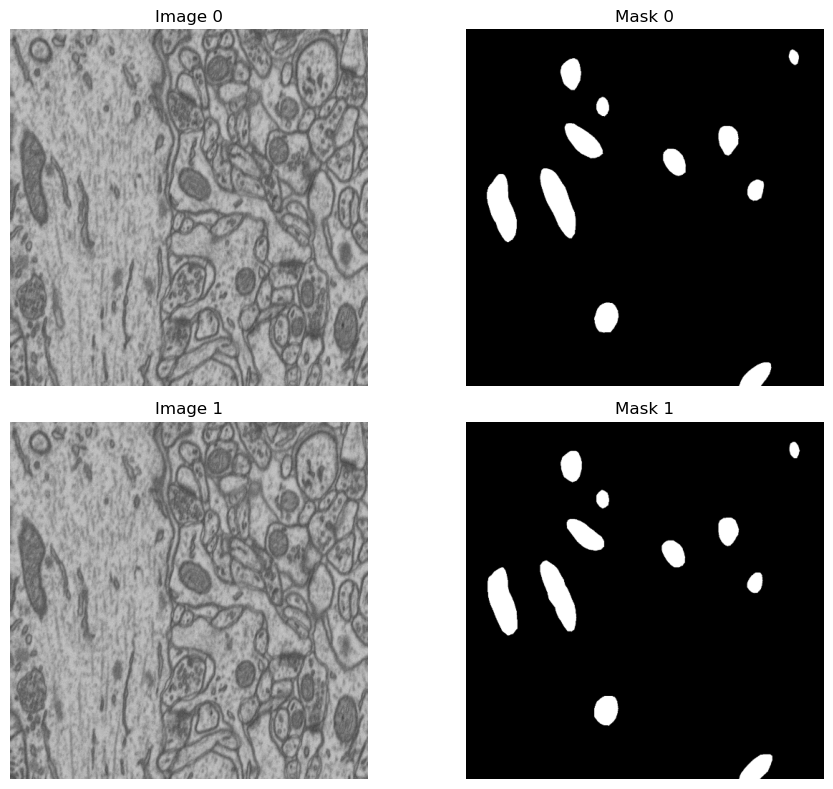

In [15]:
# Function to display images and masks
def display_images_masks(images, masks, num_samples=2):
    plt.figure(figsize=(10, num_samples * 4))
    
    for i in range(num_samples):
        # Display image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(images[i])
        plt.title(f'Image {i}')
        plt.axis('off')

        # Display mask
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title(f'Mask {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load and display images and masks from the validation generator
val_images, val_masks = next(val_generator_fn())
display_images_masks(val_images, val_masks)


In [16]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Custom callback for tracking IoU and losses
class MetricsHistory(Callback):
    def __init__(self):
        self.iou_scores = []
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        # Logs is a dictionary
        if logs is not None:
            self.iou_scores.append(logs.get('val_IOU'))  # Adjust this if your IoU metric name is different
            self.losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))

# Initialize the custom callback
metrics_history = MetricsHistory()

# Other callbacks
model_checkpoint = ModelCheckpoint('CheckPoint.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-8)
early_stop = EarlyStopping(monitor="val_loss", patience=12, mode="auto", restore_best_weights=True)

# Model fitting
epochs = 25
validation_steps = 4
with tf.device('/gpu:0'):
    model.fit(train_generator_fn(),
              validation_data=val_generator_fn(),
              steps_per_epoch=21,
              validation_steps=validation_steps,
              epochs=epochs,
              #callbacks=[model_checkpoint, reduce_lr, early_stop, metrics_history]
             )

# Access the recorded metrics
iou_scores = metrics_history.iou_scores
training_losses = metrics_history.losses
validation_losses = metrics_history.val_losses

# You can now use iou_scores, training_losses, and validation_losses as needed


Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 0.3473 - accuracy: 0.8887 - IOU: 0.4706 
Epoch 1: val_loss improved from inf to 0.23843, saving model to CheckPoint.hdf5


C:\Users\prana\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 771s 36s/step - loss: 0.3473 - accuracy: 0.8887 - IOU: 0.4706 - val_loss: 0.2384 - val_accuracy: 0.9364 - val_IOU: 0.4761 - lr: 1.0000e-04
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.9343 - IOU: 0.4806 
Epoch 2: val_loss did not improve from 0.23843
21/21 [==============================] - 727s 34s/step - loss: 0.1828 - accuracy: 0.9343 - IOU: 0.4806 - val_loss: 0.2510 - val_accuracy: 0.9354 - val_IOU: 0.4756 - lr: 1.0000e-04
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9369 - IOU: 0.4970 
Epoch 3: val_loss did not improve from 0.23843
21/21 [==============================] - 729s 35s/step - loss: 0.1376 - accuracy: 0.9369 - IOU: 0.4970 - val_loss: 0.3283 - val_accuracy: 0.9162 - val_IOU: 0.4763 - lr: 1.0000e-04
Epoch 4/25
21/21 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9467 - IOU: 0.6450 
Epoch 4: val_loss did not improve from 

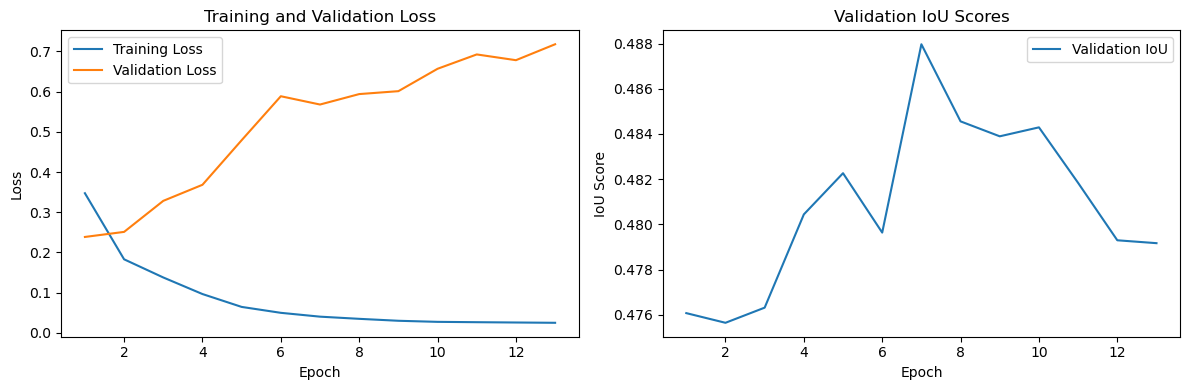

In [17]:
import matplotlib.pyplot as plt

# Assuming you have the following lists from the previous step:
iou_scores = metrics_history.iou_scores
training_losses = metrics_history.losses
validation_losses = metrics_history.val_losses

# Number of epochs - this should match the actual number of epochs run
epochs = range(1, len(training_losses) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting IoU Scores
plt.subplot(1, 2, 2)
plt.plot(epochs, iou_scores, label='Validation IoU')
plt.title('Validation IoU Scores')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()

plt.tight_layout()
plt.show()


In [35]:
import matplotlib.pyplot as plt

# Function to display original images with post-processed predicted masks
def display_with_post_processed_masks(images, predicted_masks, post_processed_masks, num_samples):
    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Original Image {i+1}')
        plt.axis('off')

        # Predicted Mask before Post-processing
        plt.subplot(num_samples, 3, 3*i + 2)
        plt.imshow(predicted_masks[i], cmap='gray')
        plt.title(f'Predicted Mask {i+1}')
        plt.axis('off')

        # Post-processed Predicted Mask
        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(post_processed_masks[i], cmap='gray')
        plt.title(f'Post-Processed Predicted Mask {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
# Define post-processing function
def post_process_mask(pred_mask, thresh_val=0.5, kernel_size=3):
    # Threshold the prediction to get binary mask
    _, binary_mask = cv2.threshold(pred_mask, thresh_val, 1, cv2.THRESH_BINARY)
    
    # Apply morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    clean_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    
    return clean_mask


1/1 [==============================] - 2s 2s/step


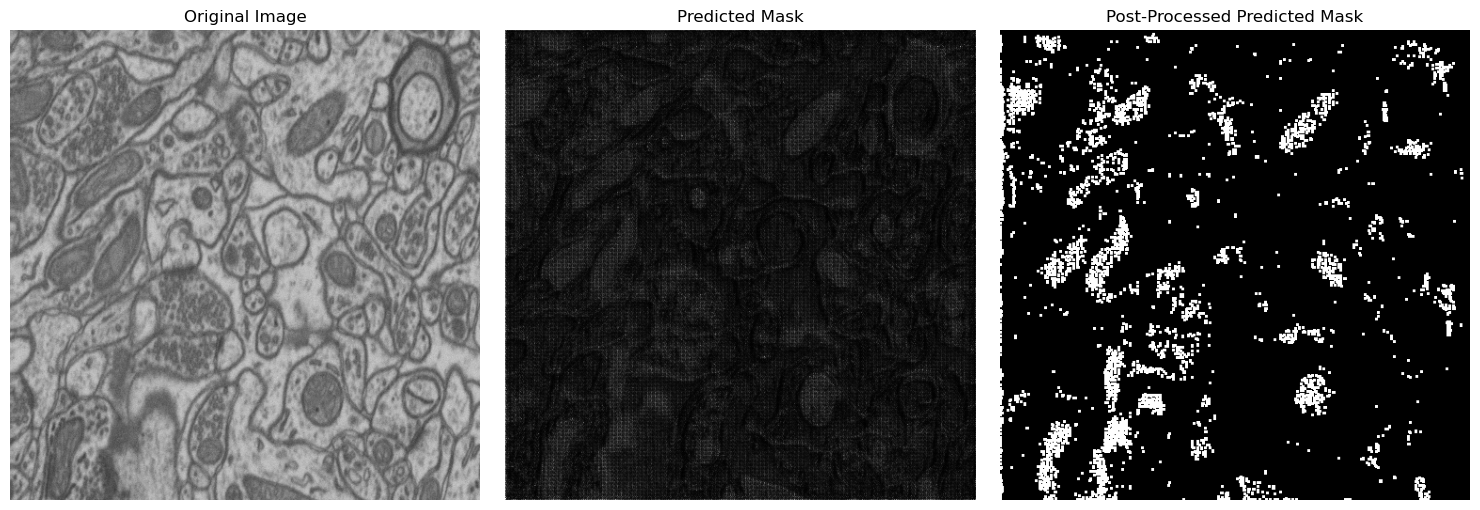

1/1 [==============================] - 1s 1s/step


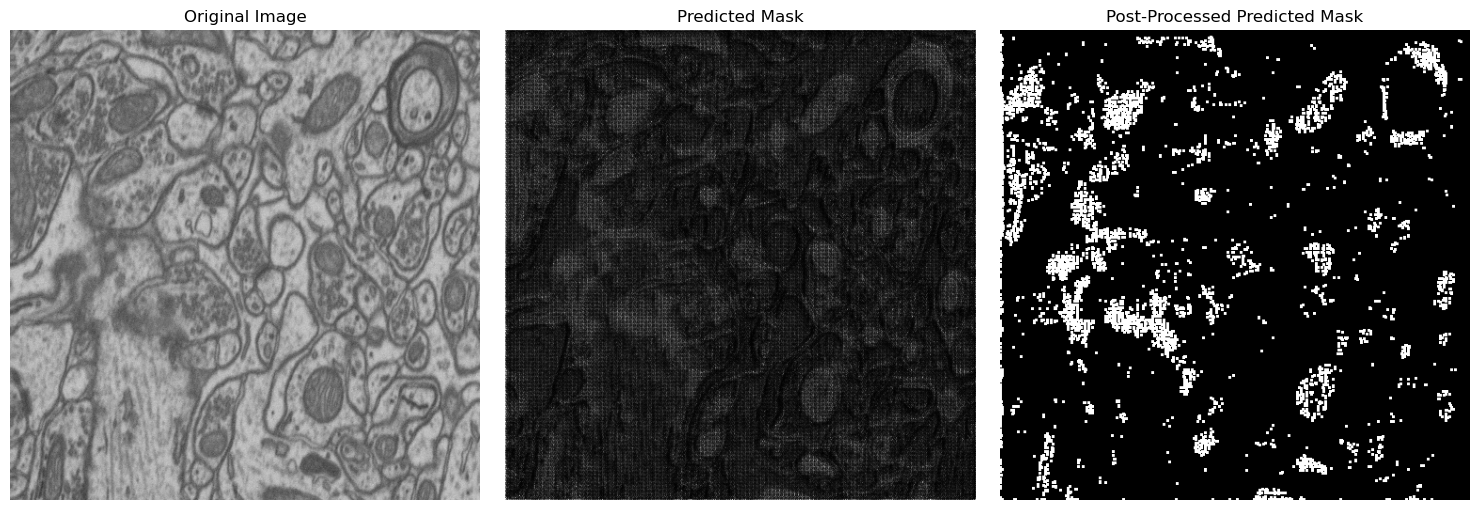

1/1 [==============================] - 1s 1s/step


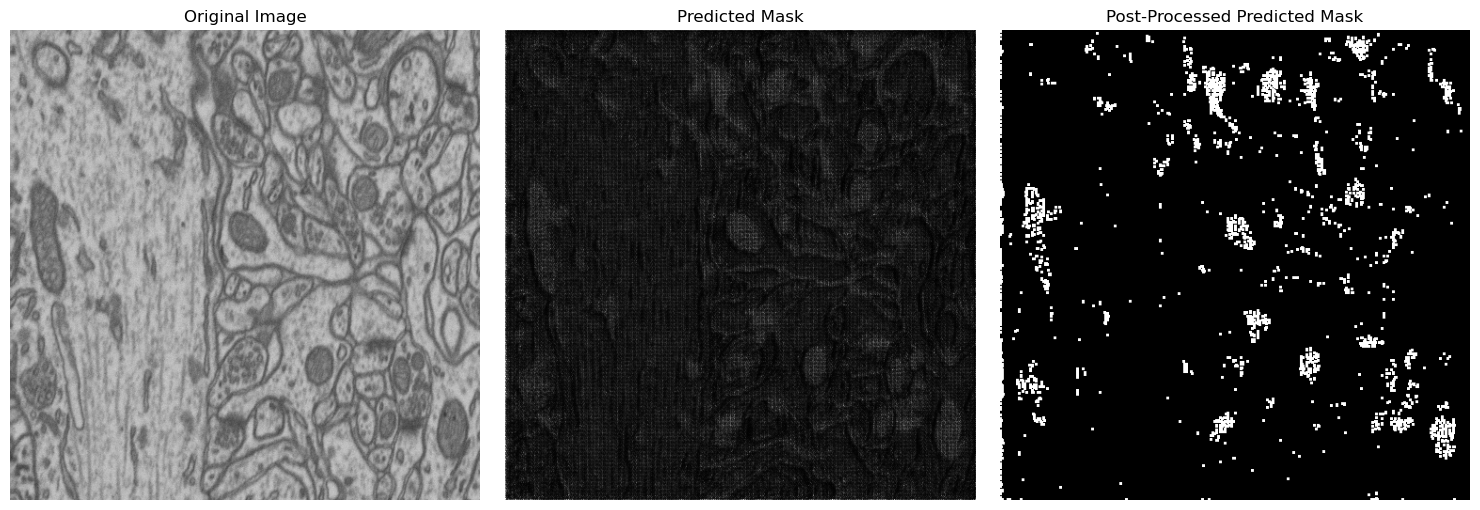

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Generate a batch of validation data
val_images, val_groundtruth = next(val_generator_fn())

# Randomly pick 2-3 indices from the batch of validation images
num_samples_to_show = random.choice([2, 3])
random_indices = random.sample(range(len(val_images)), num_samples_to_show)

for idx in random_indices:
    # Predicting on the sample image
    sample = np.expand_dims(val_images[idx], axis=0)  # Add batch dimension
    predicted_mask = model.predict(sample)
    predicted_mask = np.squeeze(predicted_mask, axis=(0, -1))  # Removing batch and channel dimensions
    
    # Post-process the predicted mask
    post_processed_mask = post_process_mask(predicted_mask, thresh_val=0.04, kernel_size=3)

    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(val_images[idx], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Predicted Mask before Post-processing
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    # Predicted Mask after Post-processing
    plt.subplot(1, 3, 3)
    plt.imshow(post_processed_mask, cmap='gray')
    plt.title('Post-Processed Predicted Mask')
    plt.axis('off')


    plt.tight_layout()
    plt.show()

In [59]:
def calculate_metrics_for_all(model, generator_fn, threshold):
    ious_raw, dices_raw, precisions_raw, recalls_raw = [], [], [], []
    ious_post, dices_post, precisions_post, recalls_post = [], [], [], []

    # Iterate over each batch in the generator
    for val_images, val_groundtruth in generator_fn():
        # Loop through each image in the current batch
        for i in range(len(val_images)):
            # Predicting on the sample image
            sample_image = np.expand_dims(val_images[i], axis=0)
            predicted_mask = model.predict(sample_image)
            predicted_mask = np.squeeze(predicted_mask, axis=(0, -1))  # Removing batch and channel dimensions

            # Binarize the raw predicted mask
            binary_predicted_mask = (predicted_mask > threshold).astype(np.uint8)

            # Post-process the predicted mask
            post_processed_mask = post_process_mask(predicted_mask, thresh_val=0.04, kernel_size=3)
            binary_post_processed_mask = (post_processed_mask > threshold).astype(np.uint8)

            # Flatten the masks and binarize the true masks if necessary
            true_mask_flattened = (val_groundtruth[i] > threshold).astype(np.uint8).flatten()
            binary_pred_mask_flattened = binary_predicted_mask.flatten()
            binary_post_processed_mask_flattened = binary_post_processed_mask.flatten()

            # Calculate metrics for raw and post-processed predictions
            iou_raw, dice_raw, precision_raw, recall_raw = calculate_segmentation_metrics(true_mask_flattened, binary_pred_mask_flattened)
            iou_post, dice_post, precision_post, recall_post = calculate_segmentation_metrics(true_mask_flattened, binary_post_processed_mask_flattened)

            # Append metrics to the respective lists
            ious_raw.append(iou_raw)
            dices_raw.append(dice_raw)
            precisions_raw.append(precision_raw)
            recalls_raw.append(recall_raw)
            ious_post.append(iou_post)
            dices_post.append(dice_post)
            precisions_post.append(precision_post)
            recalls_post.append(recall_post)

            # Print metrics for each image
            print(f"Image {i} - IOU Raw: {iou_raw}, IOU Post: {iou_post}")

    # Aggregate metrics over all batches
    mean_iou_raw = np.mean(ious_raw)
    mean_dice_raw = np.mean(dices_raw)
    mean_precision_raw = np.mean(precisions_raw)
    mean_recall_raw = np.mean(recalls_raw)
    mean_iou_post = np.mean(ious_post)
    mean_dice_post = np.mean(dices_post)
    mean_precision_post = np.mean(precisions_post)
    mean_recall_post = np.mean(recalls_post)

    # Print aggregated metrics
    print("Aggregate Metrics for Raw Predictions:")
    print(f"Mean IOU: {mean_iou_raw}, Mean Dice: {mean_dice_raw}, Mean Precision: {mean_precision_raw}, Mean Recall: {mean_recall_raw}")
    print("Aggregate Metrics for Post-Processed Predictions:")
    print(f"Mean IOU: {mean_iou_post}, Mean Dice: {mean_dice_post}, Mean Precision: {mean_precision_post}, Mean Recall: {mean_recall_post}")

# Call the function with your model and generator function
calculate_metrics_for_all(model, val_generator_fn, 0.1)


1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.02499830863946959, IOU Post: 0.03887231571516407
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.027906240101362053, IOU Post: 0.04191246938558194
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02674591381872214, IOU Post: 0.040889009106482736
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.01838309292183831, IOU Post: 0.03971104399640846
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.018217394237905676, IOU Post: 0.02709428812266688
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02067556196658252, IOU Post: 0.030722867989511175
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02170905100434181, IOU Post: 0.039657221492462626
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.024431625381744145, IOU Post: 0.03701749758199244
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02004351552713127, IOU Post: 0.03034556789562776
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02, IOU Post: 0.035033947623666344
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.028112186321141545, IOU Post: 0.04963641384388807
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.007893031748836661, IOU Post: 0.006928838951310861
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (25000

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.023986293546544833, IOU Post: 0.043470423889205995
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.01631493079311615, IOU Post: 0.028878468151621726
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.007266662695812735, IOU Post: 0.007106551204819277
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.021858665399497657, IOU Post: 0.03600449515905947
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.0230940044411547, IOU Post: 0.04869052010328292
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.03029630803359214, IOU Post: 0.0489643798059417
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened sha

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.027149904878599296, IOU Post: 0.04543761638733706
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.01623176494760633, IOU Post: 0.028465397006647363
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.01186096315413761, IOU Post: 0.018496444572321098
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.007893031748836661, IOU Post: 0.006928838951310861
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.006479070062885092, IOU Post: 0.0032883736484226956
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.023793092116073482, IOU Post: 0.03566442718785446
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatte

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.03029630803359214, IOU Post: 0.0489643798059417
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.016404684038400674, IOU Post: 0.03289371605896044
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.024876581302067262, IOU Post: 0.04866862708069172
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.0077814283243991, IOU Post: 0.006457058451150031
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02606363844468426, IOU Post: 0.04549752611324904
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.008139394670203786, IOU Post: 0.007676655567887532
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.02140402041454015, IOU Post: 0.042984134128502306
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.024690796653328483, IOU Post: 0.047604403714865615
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.01867143209267932, IOU Post: 0.03512102515424775
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.017773873082381562, IOU Post: 0.02629189367673766
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.027180489621148655, IOU Post: 0.046330599841818254
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.022926500337154418, IOU Post: 0.03612892046439092
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.024210430508783107, IOU Post: 0.03765664290612856
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.027271265476764752, IOU Post: 0.0482097299199437
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.025326797385620915, IOU Post: 0.04554191926659766
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02457286774215506, IOU Post: 0.03541487288711651
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.024097231979766754, IOU Post: 0.046498830650708485
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.022856198711240845, IOU Post: 0.041767554479418885
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.0055543837446389655, IOU Post: 0.005456255879586077
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.004697320542507443, IOU Post: 0.004089390623200092
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.024233901298361515, IOU Post: 0.03802380848558845
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatte

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02286325825752785, IOU Post: 0.04102547730030011
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.03029630803359214, IOU Post: 0.0489643798059417
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.012135001896094046, IOU Post: 0.020014295925661188
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.024084202785310475, IOU Post: 0.04690179935759504
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.022549130978075656, IOU Post: 0.04676719686015286
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.018486615425390936, IOU Post: 0.03363409328929348
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.01186096315413761, IOU Post: 0.018496444572321098
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.010434400571146137, IOU Post: 0.01952919249625218
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.024690796653328483, IOU Post: 0.047604403714865615
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.005916761917568749, IOU Post: 0.004464547964518593
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.022238514173998046, IOU Post: 0.04013280897427632
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.027906240101362053, IOU Post: 0.04191246938558194
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02585220773278426, IOU Post: 0.0437863209655789
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.024233901298361515, IOU Post: 0.03802380848558845
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.029156670972504153, IOU Post: 0.05766596089176734
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.02749466698269732, IOU Post: 0.04783076371459304
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.006247533868209917, IOU Post: 0.005186958504331965
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.023986293546544833, IOU Post: 0.043470423889205995
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.022398981864460706, IOU Post: 0.030546968916366133
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.027291381668946648, IOU Post: 0.04916474263207932
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02269882615608403, IOU Post: 0.03333702024112377
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.024876581302067262, IOU Post: 0.04866862708069172
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.022857663236499407, IOU Post: 0.03313561055430558
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.022856198711240845, IOU Post: 0.041767554479418885
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.026993906797835043, IOU Post: 0.039587036783809655
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.008107951583946256, IOU Post: 0.009366024226782666
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.02269427265393923, IOU Post: 0.049229179910998094
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.027903664379127283, IOU Post: 0.04474201264308902
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.0055543837446389655, IOU Post: 0.005456255879586077
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.01186096315413761, IOU Post: 0.018496444572321098
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.022856198711240845, IOU Post: 0.041767554479418885
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.006226312939902545, IOU Post: 0.004697256115025491
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.027291381668946648, IOU Post: 0.04916474263207932
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.025779996434302014, IOU Post: 0.050222582945965225
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02, IOU Post: 0.035033947623666344
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02543652951483294, IOU Post: 0.052473136262909226
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (25000

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.026757588111032873, IOU Post: 0.04981956956307277
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.018261883175754435, IOU Post: 0.0300276570525484
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.029537875178656504, IOU Post: 0.048235544217687075
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.024876581302067262, IOU Post: 0.04866862708069172
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.026707484429431015, IOU Post: 0.04758304472952539
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.018486615425390936, IOU Post: 0.03363409328929348
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.013059800137471581, IOU Post: 0.026509154386392238
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.023571341784455874, IOU Post: 0.047014260249554365
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.025214181235634184, IOU Post: 0.04660742386374155
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.027850479833568215, IOU Post: 0.050509107231448885
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.02674591381872214, IOU Post: 0.040889009106482736
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02275910364145658, IOU Post: 0.042185927703382614
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.01186096315413761, IOU Post: 0.018496444572321098
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.027180489621148655, IOU Post: 0.046330599841818254
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02749466698269732, IOU Post: 0.04783076371459304
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.027918781725888325, IOU Post: 0.06117316054224572
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.018486615425390936, IOU Post: 0.03363409328929348
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.022620256670667527, IOU Post: 0.03474184299198426
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.027271265476764752, IOU Post: 0.0482097299199437
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.024811909716664, IOU Post: 0.0374377468658767
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.022238514173998046, IOU Post: 0.04013280897427632
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shap

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.023234020551929167, IOU Post: 0.030325793020560588
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.022216112180368435, IOU Post: 0.04129387474191328
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.022549130978075656, IOU Post: 0.04676719686015286
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.01234300563014292, IOU Post: 0.022740524781341108
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.010434400571146137, IOU Post: 0.01952919249625218
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.021443572454957444, IOU Post: 0.04510070431236871
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.01867143209267932, IOU Post: 0.03512102515424775
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.019523060796645703, IOU Post: 0.03504906869617464
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.026735270379338177, IOU Post: 0.04725791728108981
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.008107951583946256, IOU Post: 0.009366024226782666
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.027291381668946648, IOU Post: 0.04916474263207932
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.022926500337154418, IOU Post: 0.03612892046439092
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02269882615608403, IOU Post: 0.03333702024112377
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.029541474803813476, IOU Post: 0.04761387107294271
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02585220773278426, IOU Post: 0.0437863209655789
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.025761447613785484, IOU Post: 0.03565475922338844
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.023234020551929167, IOU Post: 0.030325793020560588
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.017473974930953897, IOU Post: 0.03529457697263109
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.017773873082381562, IOU Post: 0.02629189367673766
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.012882787750791975, IOU Post: 0.02349509843636069
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02543652951483294, IOU Post: 0.052473136262909226
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.013059800137471581, IOU Post: 0.026509154386392238
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.022398981864460706, IOU Post: 0.030546968916366133
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.024856863566540988, IOU Post: 0.050432079008733026
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatte

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.028112186321141545, IOU Post: 0.04963641384388807
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.023571341784455874, IOU Post: 0.047014260249554365
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.025761447613785484, IOU Post: 0.03565475922338844
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.012882787750791975, IOU Post: 0.02349509843636069
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.022236614853195166, IOU Post: 0.034972483578909995
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.027906240101362053, IOU Post: 0.04191246938558194
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.026228007063902152, IOU Post: 0.04272749354119284
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.022544443340947462, IOU Post: 0.030997186071051706
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.006247533868209917, IOU Post: 0.005186958504331965
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.0077814283243991, IOU Post: 0.006457058451150031
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.017773873082381562, IOU Post: 0.02629189367673766
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.012368449603992622, IOU Post: 0.020827318843568275
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.01234300563014292, IOU Post: 0.022740524781341108
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02749466698269732, IOU Post: 0.04783076371459304
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.027621450287858205, IOU Post: 0.06247316444826106
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.025214181235634184, IOU Post: 0.04660742386374155
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02286325825752785, IOU Post: 0.04102547730030011
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.026258653885543402, IOU Post: 0.04566418037920628
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.006247533868209917, IOU Post: 0.005186958504331965
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.024084202785310475, IOU Post: 0.04690179935759504
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.01186096315413761, IOU Post: 0.018496444572321098
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.027906240101362053, IOU Post: 0.04191246938558194
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.022544443340947462, IOU Post: 0.030997186071051706
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.019523060796645703, IOU Post: 0.03504906869617464
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.027903664379127283, IOU Post: 0.04474201264308902
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.03029630803359214, IOU Post: 0.0489643798059417
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.022857663236499407, IOU Post: 0.03313561055430558
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02397040690505549, IOU Post: 0.04005963570363648
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.023949311166656977, IOU Post: 0.040462867800997296
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02921998031496063, IOU Post: 0.0613974995718445
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.01838309292183831, IOU Post: 0.03971104399640846
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.021443572454957444, IOU Post: 0.04510070431236871
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.010176939979183532, IOU Post: 0.014199126859661765
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.0230940044411547, IOU Post: 0.04869052010328292
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.025779996434302014, IOU Post: 0.050222582945965225
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.02585220773278426, IOU Post: 0.0437863209655789
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened sh

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02749466698269732, IOU Post: 0.04783076371459304
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.028398632658427556, IOU Post: 0.0631444434652331
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.022731166828488206, IOU Post: 0.042471515498019356
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.02331771720613288, IOU Post: 0.04537899578678829
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.022934401602403606, IOU Post: 0.04503033131124592
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.007266662695812735, IOU Post: 0.007106551204819277
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.021975545162562688, IOU Post: 0.04717876749081603
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.018261883175754435, IOU Post: 0.0300276570525484
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.023566084788029924, IOU Post: 0.03320456800287083
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.022620256670667527, IOU Post: 0.03474184299198426
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.021858665399497657, IOU Post: 0.03600449515905947
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.013658432481459745, IOU Post: 0.02420965058236273
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.022656525785436924, IOU Post: 0.03613744075829384
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02085775995063252, IOU Post: 0.03282877163098603
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.025646830530401035, IOU Post: 0.043242539902845246
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.02067556196658252, IOU Post: 0.030722867989511175
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.0265454180736184, IOU Post: 0.04454066705675834
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.024273888031429772, IOU Post: 0.045914566000248354
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.022149349902197676, IOU Post: 0.036706650470695414
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.02726199068302605, IOU Post: 0.04567601842169666
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.0192629296995974, IOU Post: 0.034580345028106224
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.024084202785310475, IOU Post: 0.04690179935759504
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.01838972850073559, IOU Post: 0.030018606574322926
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.027271265476764752, IOU Post: 0.0482097299199437
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.0055543837446389655, IOU Post: 0.005456255879586077
1/1 [==============================] - 4s 4s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.024431625381744145, IOU Post: 0.03701749758199244
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.022934401602403606, IOU Post: 0.04503033131124592
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.022719542888238894, IOU Post: 0.04214102903538964
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.0077814283243991, IOU Post: 0.006457058451150031
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.02749466698269732, IOU Post: 0.04783076371459304
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.026993906797835043, IOU Post: 0.039587036783809655
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.024097231979766754, IOU Post: 0.046498830650708485
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.006247533868209917, IOU Post: 0.005186958504331965
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks fl

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.03087511658572669, IOU Post: 0.04834724825353553
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.0230940044411547, IOU Post: 0.04869052010328292
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02543652951483294, IOU Post: 0.052473136262909226
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened sh

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.022216112180368435, IOU Post: 0.04129387474191328
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.018217394237905676, IOU Post: 0.02709428812266688
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.026735270379338177, IOU Post: 0.04725791728108981
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02085775995063252, IOU Post: 0.03282877163098603
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02457286774215506, IOU Post: 0.03541487288711651
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.0249835418038183, IOU Post: 0.04344561016013252
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatt

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.01623176494760633, IOU Post: 0.028465397006647363
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.02536304624238774, IOU Post: 0.05083917946896368
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.022040469488554888, IOU Post: 0.04082698130938707
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.022849540116850812, IOU Post: 0.04207681914688284
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.026228007063902152, IOU Post: 0.04272749354119284
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.024856863566540988, IOU Post: 0.050432079008733026
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02543652951483294, IOU Post: 0.052473136262909226
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.0192629296995974, IOU Post: 0.034580345028106224
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.012882787750791975, IOU Post: 0.02349509843636069
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.024016586995334908, IOU Post: 0.04553793468955114
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.017773873082381562, IOU Post: 0.02629189367673766
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.016404684038400674, IOU Post: 0.03289371605896044
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.018261883175754435, IOU Post: 0.0300276570525484
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.02286325825752785, IOU Post: 0.04102547730030011
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.027271265476764752, IOU Post: 0.0482097299199437
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened sh

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.01867143209267932, IOU Post: 0.03512102515424775
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02097093791281374, IOU Post: 0.04343486618364631
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.02457286774215506, IOU Post: 0.03541487288711651
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened sh

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.010176939979183532, IOU Post: 0.014199126859661765
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02870931815369385, IOU Post: 0.06043482011905789
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.017473974930953897, IOU Post: 0.03529457697263109
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.024016586995334908, IOU Post: 0.04553793468955114
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.006247533868209917, IOU Post: 0.005186958504331965
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02749466698269732, IOU Post: 0.04783076371459304
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.005916761917568749, IOU Post: 0.004464547964518593
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.007893031748836661, IOU Post: 0.006928838951310861
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.02140402041454015, IOU Post: 0.042984134128502306
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.026228007063902152, IOU Post: 0.04272749354119284
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.01958183311224812, IOU Post: 0.03346394984326019
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.0249835418038183, IOU Post: 0.04344561016013252
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened sh

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.026223776223776224, IOU Post: 0.04731503744852555
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.023986293546544833, IOU Post: 0.043470423889205995
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02849833219987694, IOU Post: 0.041911003794411865
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02684851887322083, IOU Post: 0.044885387139254065
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.012882787750791975, IOU Post: 0.02349509843636069
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.010176939979183532, IOU Post: 0.014199126859661765
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.025214181235634184, IOU Post: 0.04660742386374155
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.029541474803813476, IOU Post: 0.04761387107294271
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.027903664379127283, IOU Post: 0.04474201264308902
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.022398981864460706, IOU Post: 0.030546968916366133
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.022216112180368435, IOU Post: 0.04129387474191328
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.026964586289976566, IOU Post: 0.04283954764304109
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.024273888031429772, IOU Post: 0.045914566000248354
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.008107951583946256, IOU Post: 0.009366024226782666
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.026735270379338177, IOU Post: 0.04725791728108981
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.023167100855973205, IOU Post: 0.0405396944653143
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.012085078955849178, IOU Post: 0.022761443367858337
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.023188671463269327, IOU Post: 0.04183432134410418
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.02275910364145658, IOU Post: 0.042185927703382614
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.019523060796645703, IOU Post: 0.03504906869617464
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.024874615757967965, IOU Post: 0.04940418495923371
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.004452793432129688, IOU Post: 0.002076777847702958
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.022236614853195166, IOU Post: 0.034972483578909995
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.02726199068302605, IOU Post: 0.04567601842169666
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.024671445639187575, IOU Post: 0.050708333333333334
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.024097231979766754, IOU Post: 0.046498830650708485
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.027918781725888325, IOU Post: 0.06117316054224572
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02749466698269732, IOU Post: 0.04783076371459304
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.026707484429431015, IOU Post: 0.04758304472952539
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02536304624238774, IOU Post: 0.05083917946896368
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.023986293546544833, IOU Post: 0.043470423889205995
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.029156670972504153, IOU Post: 0.05766596089176734
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.025761447613785484, IOU Post: 0.03565475922338844
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.021975545162562688, IOU Post: 0.04717876749081603
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.018217394237905676, IOU Post: 0.02709428812266688
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.006521177685950413, IOU Post: 0.006725443653215779
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02543652951483294, IOU Post: 0.052473136262909226
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02429136344000266, IOU Post: 0.03763883633449819
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.027710178785813947, IOU Post: 0.0473554601521128
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.0249835418038183, IOU Post: 0.04344561016013252
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.027291381668946648, IOU Post: 0.04916474263207932
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.027850479833568215, IOU Post: 0.050509107231448885
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.026964586289976566, IOU Post: 0.04283954764304109
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.028112186321141545, IOU Post: 0.04963641384388807
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.023566084788029924, IOU Post: 0.03320456800287083
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.004697320542507443, IOU Post: 0.004089390623200092
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02674591381872214, IOU Post: 0.040889009106482736
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.024273888031429772, IOU Post: 0.045914566000248354
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.025090986940697925, IOU Post: 0.04721440967027706
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02849833219987694, IOU Post: 0.041911003794411865
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.008139394670203786, IOU Post: 0.007676655567887532
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.027850479833568215, IOU Post: 0.050509107231448885
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.0257770020809559, IOU Post: 0.04250273622765414
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.006226312939902545, IOU Post: 0.004697256115025491
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.024016586995334908, IOU Post: 0.04553793468955114
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.022849540116850812, IOU Post: 0.04207681914688284
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02397040690505549, IOU Post: 0.04005963570363648
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.022934401602403606, IOU Post: 0.04503033131124592
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.012135001896094046, IOU Post: 0.020014295925661188
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.0230940044411547, IOU Post: 0.04869052010328292
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.006479070062885092, IOU Post: 0.0032883736484226956
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.026964586289976566, IOU Post: 0.04283954764304109
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02749466698269732, IOU Post: 0.04783076371459304
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.022236614853195166, IOU Post: 0.034972483578909995
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.02067556196658252, IOU Post: 0.030722867989511175
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02684851887322083, IOU Post: 0.044885387139254065
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.022620256670667527, IOU Post: 0.03474184299198426
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.017773873082381562, IOU Post: 0.02629189367673766
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.024273888031429772, IOU Post: 0.045914566000248354
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02512440407836587, IOU Post: 0.036878431015238834
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.027291381668946648, IOU Post: 0.04916474263207932
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.0230940044411547, IOU Post: 0.04869052010328292
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.027180489621148655, IOU Post: 0.046330599841818254
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.009123982214009355, IOU Post: 0.00839458737053124
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.004697320542507443, IOU Post: 0.004089390623200092
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02749466698269732, IOU Post: 0.04783076371459304
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.023167100855973205, IOU Post: 0.0405396944653143
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.022549130978075656, IOU Post: 0.04676719686015286
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.005916761917568749, IOU Post: 0.004464547964518593
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.023566084788029924, IOU Post: 0.03320456800287083
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.006247533868209917, IOU Post: 0.005186958504331965
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.026228007063902152, IOU Post: 0.04272749354119284
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02085775995063252, IOU Post: 0.03282877163098603
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.023571341784455874, IOU Post: 0.047014260249554365
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.027906240101362053, IOU Post: 0.04191246938558194
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.025768384558970597, IOU Post: 0.042939124563969845
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.009123982214009355, IOU Post: 0.00839458737053124
1/1 [==============================] - 5s 5s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.022398981864460706, IOU Post: 0.030546968916366133
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.02536304624238774, IOU Post: 0.05083917946896368
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02499830863946959, IOU Post: 0.03887231571516407
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.022544443340947462, IOU Post: 0.030997186071051706
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.016404684038400674, IOU Post: 0.03289371605896044
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.026735270379338177, IOU Post: 0.04725791728108981
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.024876581302067262, IOU Post: 0.04866862708069172
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.018217394237905676, IOU Post: 0.02709428812266688
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02726199068302605, IOU Post: 0.04567601842169666
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.024431625381744145, IOU Post: 0.03701749758199244
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.024671445639187575, IOU Post: 0.050708333333333334
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.022236614853195166, IOU Post: 0.034972483578909995
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02085775995063252, IOU Post: 0.03282877163098603
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.024690796653328483, IOU Post: 0.047604403714865615
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.025090986940697925, IOU Post: 0.04721440967027706
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.029156670972504153, IOU Post: 0.05766596089176734
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.004697320542507443, IOU Post: 0.004089390623200092
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.012938805811857038, IOU Post: 0.019370558375634516
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.026729986431478968, IOU Post: 0.05236154399424599
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.018261883175754435, IOU Post: 0.0300276570525484
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.026223776223776224, IOU Post: 0.04731503744852555
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.02543652951483294, IOU Post: 0.052473136262909226
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.021443572454957444, IOU Post: 0.04510070431236871
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.006479070062885092, IOU Post: 0.0032883736484226956
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.02749466698269732, IOU Post: 0.04783076371459304
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.026707484429431015, IOU Post: 0.04758304472952539
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.01834001979888501, IOU Post: 0.0396255254107757
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened sh

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.010176939979183532, IOU Post: 0.014199126859661765
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.024210430508783107, IOU Post: 0.03765664290612856
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02686536555354274, IOU Post: 0.04695141046951411
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.02, IOU Post: 0.035033947623666344
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.02004351552713127, IOU Post: 0.03034556789562776
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.020401724681880323, IOU Post: 0.038664255761166465
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.018261883175754435, IOU Post: 0.0300276570525484
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.02067556196658252, IOU Post: 0.030722867989511175
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.009123982214009355, IOU Post: 0.00839458737053124
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.012135001896094046, IOU Post: 0.020014295925661188
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.024811909716664, IOU Post: 0.0374377468658767
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.025090986940697925, IOU Post: 0.04721440967027706
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened sh

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.0230940044411547, IOU Post: 0.04869052010328292
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.022856198711240845, IOU Post: 0.041767554479418885
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02749466698269732, IOU Post: 0.04783076371459304
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02870931815369385, IOU Post: 0.06043482011905789
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.017473974930953897, IOU Post: 0.03529457697263109
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.024658461278179587, IOU Post: 0.04782317090951506
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.03029630803359214, IOU Post: 0.0489643798059417
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.006479070062885092, IOU Post: 0.0032883736484226956
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.018593532107045622, IOU Post: 0.03355704697986577
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.024084202785310475, IOU Post: 0.04690179935759504
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.024856863566540988, IOU Post: 0.050432079008733026
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.025646830530401035, IOU Post: 0.043242539902845246
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.02474460839954597, IOU Post: 0.04185448923150628
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.028112186321141545, IOU Post: 0.04963641384388807
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.027621450287858205, IOU Post: 0.06247316444826106
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02004351552713127, IOU Post: 0.03034556789562776
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.027291381668946648, IOU Post: 0.04916474263207932
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02286325825752785, IOU Post: 0.04102547730030011
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.018261883175754435, IOU Post: 0.0300276570525484
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.013658432481459745, IOU Post: 0.02420965058236273
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.016404684038400674, IOU Post: 0.03289371605896044
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.03029630803359214, IOU Post: 0.0489643798059417
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.02429136344000266, IOU Post: 0.03763883633449819
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02275910364145658, IOU Post: 0.042185927703382614
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened sh

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.024658461278179587, IOU Post: 0.04782317090951506
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.024210430508783107, IOU Post: 0.03765664290612856
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.005831676607024519, IOU Post: 0.0021330489268097585
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.010434400571146137, IOU Post: 0.01952919249625218
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.022934401602403606, IOU Post: 0.04503033131124592
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.006479070062885092, IOU Post: 0.0032883736484226956
1/1 [==============================] - 6s 6s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02286325825752785, IOU Post: 0.04102547730030011
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.017773873082381562, IOU Post: 0.02629189367673766
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.029541474803813476, IOU Post: 0.04761387107294271
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.028426579757378237, IOU Post: 0.059256779377301644
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.027918781725888325, IOU Post: 0.06117316054224572
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.027710178785813947, IOU Post: 0.0473554601521128
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.027149904878599296, IOU Post: 0.04543761638733706
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02870931815369385, IOU Post: 0.06043482011905789
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.01958183311224812, IOU Post: 0.03346394984326019
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.012085078955849178, IOU Post: 0.022761443367858337
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.022544443340947462, IOU Post: 0.030997186071051706
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.006479070062885092, IOU Post: 0.0032883736484226956
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatt

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.024811909716664, IOU Post: 0.0374377468658767
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.022934401602403606, IOU Post: 0.04503033131124592
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.02286325825752785, IOU Post: 0.04102547730030011
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shap

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.018217394237905676, IOU Post: 0.02709428812266688
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.004452793432129688, IOU Post: 0.002076777847702958
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.03029630803359214, IOU Post: 0.0489643798059417
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.024856863566540988, IOU Post: 0.050432079008733026
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.005831676607024519, IOU Post: 0.0021330489268097585
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02, IOU Post: 0.035033947623666344
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.024016586995334908, IOU Post: 0.04553793468955114
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.024690796653328483, IOU Post: 0.047604403714865615
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.025698798328108674, IOU Post: 0.04084139413480731
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.0236013986013986, IOU Post: 0.050529815084147105
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.01234300563014292, IOU Post: 0.022740524781341108
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.027903664379127283, IOU Post: 0.04474201264308902
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.023566084788029924, IOU Post: 0.03320456800287083
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.023571341784455874, IOU Post: 0.047014260249554365
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.025761447613785484, IOU Post: 0.03565475922338844
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.029156670972504153, IOU Post: 0.05766596089176734
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.02275910364145658, IOU Post: 0.042185927703382614
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.025214181235634184, IOU Post: 0.04660742386374155
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02606363844468426, IOU Post: 0.04549752611324904
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.021975545162562688, IOU Post: 0.04717876749081603
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.024671445639187575, IOU Post: 0.050708333333333334
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.023167100855973205, IOU Post: 0.0405396944653143
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02543652951483294, IOU Post: 0.052473136262909226
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02429136344000266, IOU Post: 0.03763883633449819
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.012135001896094046, IOU Post: 0.020014295925661188
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.024658461278179587, IOU Post: 0.04782317090951506
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.01838309292183831, IOU Post: 0.03971104399640846
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.023986293546544833, IOU Post: 0.043470423889205995
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.024876581302067262, IOU Post: 0.04866862708069172
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.025729170358294647, IOU Post: 0.05100048804294778
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.023188671463269327, IOU Post: 0.04183432134410418
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.024210430508783107, IOU Post: 0.03765664290612856
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.013658432481459745, IOU Post: 0.02420965058236273
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.02674591381872214, IOU Post: 0.040889009106482736
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.022857663236499407, IOU Post: 0.03313561055430558
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.022398981864460706, IOU Post: 0.030546968916366133
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.024273888031429772, IOU Post: 0.045914566000248354
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.005916761917568749, IOU Post: 0.004464547964518593
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.025779996434302014, IOU Post: 0.050222582945965225
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatte

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02085775995063252, IOU Post: 0.03282877163098603
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.022926500337154418, IOU Post: 0.03612892046439092
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.023793092116073482, IOU Post: 0.03566442718785446
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.023986293546544833, IOU Post: 0.043470423889205995
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.012085078955849178, IOU Post: 0.022761443367858337
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02397040690505549, IOU Post: 0.04005963570363648
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.01186096315413761, IOU Post: 0.018496444572321098
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.0192629296995974, IOU Post: 0.034580345028106224
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.024671445639187575, IOU Post: 0.050708333333333334
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.022731166828488206, IOU Post: 0.042471515498019356
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02512440407836587, IOU Post: 0.036878431015238834
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.020431617928744733, IOU Post: 0.03623851386292215
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.022656525785436924, IOU Post: 0.03613744075829384
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02684851887322083, IOU Post: 0.044885387139254065
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.022236614853195166, IOU Post: 0.034972483578909995
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.01623176494760633, IOU Post: 0.028465397006647363
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02585220773278426, IOU Post: 0.0437863209655789
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.025761447613785484, IOU Post: 0.03565475922338844
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.029156670972504153, IOU Post: 0.05766596089176734
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02674591381872214, IOU Post: 0.040889009106482736
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.027180489621148655, IOU Post: 0.046330599841818254
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.012060245651086534, IOU Post: 0.018377108332634052
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02585220773278426, IOU Post: 0.0437863209655789
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.01867143209267932, IOU Post: 0.03512102515424775
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.026757588111032873, IOU Post: 0.04981956956307277
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.024097231979766754, IOU Post: 0.046498830650708485
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.005916761917568749, IOU Post: 0.004464547964518593
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.017773873082381562, IOU Post: 0.02629189367673766
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.006226312939902545, IOU Post: 0.004697256115025491
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.026228007063902152, IOU Post: 0.04272749354119284
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.018593532107045622, IOU Post: 0.03355704697986577
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02275910364145658, IOU Post: 0.042185927703382614
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.0230940044411547, IOU Post: 0.04869052010328292
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.022719542888238894, IOU Post: 0.04214102903538964
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.023234020551929167, IOU Post: 0.030325793020560588
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.024207125631341857, IOU Post: 0.04158087218414825
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.0236013986013986, IOU Post: 0.050529815084147105
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.024856863566540988, IOU Post: 0.050432079008733026
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.018486615425390936, IOU Post: 0.03363409328929348
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.028426579757378237, IOU Post: 0.059256779377301644
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.008139394670203786, IOU Post: 0.007676655567887532
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.027710178785813947, IOU Post: 0.0473554601521128
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.022040469488554888, IOU Post: 0.04082698130938707
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.0055543837446389655, IOU Post: 0.005456255879586077
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.019523060796645703, IOU Post: 0.03504906869617464
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.022216112180368435, IOU Post: 0.04129387474191328
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.012882787750791975, IOU Post: 0.02349509843636069
1/1 [==============================] - 7s 7s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.0230940044411547, IOU Post: 0.04869052010328292
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02674591381872214, IOU Post: 0.040889009106482736
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02132385606397157, IOU Post: 0.030681862996411246
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.008107951583946256, IOU Post: 0.009366024226782666
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.0077814283243991, IOU Post: 0.006457058451150031
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.023986293546544833, IOU Post: 0.043470423889205995
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.023566084788029924, IOU Post: 0.03320456800287083
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.010176939979183532, IOU Post: 0.014199126859661765
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.017773873082381562, IOU Post: 0.02629189367673766
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.023566084788029924, IOU Post: 0.03320456800287083
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.01838309292183831, IOU Post: 0.03971104399640846
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.029541474803813476, IOU Post: 0.04761387107294271
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02749466698269732, IOU Post: 0.04783076371459304
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.0055543837446389655, IOU Post: 0.005456255879586077
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.008107951583946256, IOU Post: 0.009366024226782666
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.004452793432129688, IOU Post: 0.002076777847702958
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatt

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.0192629296995974, IOU Post: 0.034580345028106224
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.022238514173998046, IOU Post: 0.04013280897427632
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.023949311166656977, IOU Post: 0.040462867800997296
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.022934401602403606, IOU Post: 0.04503033131124592
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02286325825752785, IOU Post: 0.04102547730030011
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.023167100855973205, IOU Post: 0.0405396944653143
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.027903664379127283, IOU Post: 0.04474201264308902
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.022398981864460706, IOU Post: 0.030546968916366133
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.024233901298361515, IOU Post: 0.03802380848558845
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.007266662695812735, IOU Post: 0.007106551204819277
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.022719542888238894, IOU Post: 0.04214102903538964
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.020431617928744733, IOU Post: 0.03623851386292215
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.024097231979766754, IOU Post: 0.046498830650708485
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.027903664379127283, IOU Post: 0.04474201264308902
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.027271265476764752, IOU Post: 0.0482097299199437
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.018486615425390936, IOU Post: 0.03363409328929348
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.025729170358294647, IOU Post: 0.05100048804294778
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02536304624238774, IOU Post: 0.05083917946896368
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.024210430508783107, IOU Post: 0.03765664290612856
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.01623176494760633, IOU Post: 0.028465397006647363
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02, IOU Post: 0.035033947623666344
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.023986293546544833, IOU Post: 0.043470423889205995
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.027621450287858205, IOU Post: 0.06247316444826106
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02331771720613288, IOU Post: 0.04537899578678829
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.024658461278179587, IOU Post: 0.04782317090951506
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.004452793432129688, IOU Post: 0.002076777847702958
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.023234020551929167, IOU Post: 0.030325793020560588
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.009123982214009355, IOU Post: 0.00839458737053124
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.024876581302067262, IOU Post: 0.04866862708069172
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.01623176494760633, IOU Post: 0.028465397006647363
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.027918781725888325, IOU Post: 0.06117316054224572
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.004697320542507443, IOU Post: 0.004089390623200092
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.025761447613785484, IOU Post: 0.03565475922338844
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.012368449603992622, IOU Post: 0.020827318843568275
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.0249835418038183, IOU Post: 0.04344561016013252
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.019523060796645703, IOU Post: 0.03504906869617464
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.02429136344000266, IOU Post: 0.03763883633449819
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02, IOU Post: 0.035033947623666344
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.026993906797835043, IOU Post: 0.039587036783809655
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.017773873082381562, IOU Post: 0.02629189367673766
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.0236013986013986, IOU Post: 0.050529815084147105
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.022849540116850812, IOU Post: 0.04207681914688284
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.012368449603992622, IOU Post: 0.020827318843568275
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.005916761917568749, IOU Post: 0.004464547964518593
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.027271265476764752, IOU Post: 0.0482097299199437
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02457286774215506, IOU Post: 0.03541487288711651
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.013658432481459745, IOU Post: 0.02420965058236273
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.024016586995334908, IOU Post: 0.04553793468955114
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.02429136344000266, IOU Post: 0.03763883633449819
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.03029630803359214, IOU Post: 0.0489643798059417
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.026993906797835043, IOU Post: 0.039587036783809655
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02215681919147046, IOU Post: 0.04496666124573101
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.02512440407836587, IOU Post: 0.036878431015238834
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.01631493079311615, IOU Post: 0.028878468151621726
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.027291381668946648, IOU Post: 0.04916474263207932
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.027149904878599296, IOU Post: 0.04543761638733706
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.01234300563014292, IOU Post: 0.022740524781341108
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.017473974930953897, IOU Post: 0.03529457697263109
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.024273888031429772, IOU Post: 0.045914566000248354
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.007893031748836661, IOU Post: 0.006928838951310861
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.027906240101362053, IOU Post: 0.04191246938558194
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.004452793432129688, IOU Post: 0.002076777847702958
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.02, IOU Post: 0.035033947623666344
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (25000

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.026707484429431015, IOU Post: 0.04758304472952539
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.018486615425390936, IOU Post: 0.03363409328929348
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.022719542888238894, IOU Post: 0.04214102903538964
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.025090986940697925, IOU Post: 0.04721440967027706
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.016404684038400674, IOU Post: 0.03289371605896044
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.01838972850073559, IOU Post: 0.030018606574322926
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.005831676607024519, IOU Post: 0.0021330489268097585
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.022398981864460706, IOU Post: 0.030546968916366133
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.006521177685950413, IOU Post: 0.006725443653215779
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatt

1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.006247533868209917, IOU Post: 0.005186958504331965
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.01623176494760633, IOU Post: 0.028465397006647363
1/1 [==============================] - 8s 8s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.024016586995334908, IOU Post: 0.04553793468955114
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.024097231979766754, IOU Post: 0.046498830650708485
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02085775995063252, IOU Post: 0.03282877163098603
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.018217394237905676, IOU Post: 0.02709428812266688
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.02215681919147046, IOU Post: 0.04496666124573101
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.02674591381872214, IOU Post: 0.040889009106482736
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.027291381668946648, IOU Post: 0.04916474263207932
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.006226312939902545, IOU Post: 0.004697256115025491
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.024671445639187575, IOU Post: 0.050708333333333334
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02140402041454015, IOU Post: 0.042984134128502306
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.023234020551929167, IOU Post: 0.030325793020560588
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.023986293546544833, IOU Post: 0.043470423889205995
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.024273888031429772, IOU Post: 0.045914566000248354
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatte

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.023571341784455874, IOU Post: 0.047014260249554365
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.025326797385620915, IOU Post: 0.04554191926659766
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.008107951583946256, IOU Post: 0.009366024226782666
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.023793092116073482, IOU Post: 0.03566442718785446
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.028426579757378237, IOU Post: 0.059256779377301644
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.01631493079311615, IOU Post: 0.028878468151621726
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02827568795758647, IOU Post: 0.05777324320877439
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.017473974930953897, IOU Post: 0.03529457697263109
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.021858665399497657, IOU Post: 0.03600449515905947
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.022719542888238894, IOU Post: 0.04214102903538964
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.027621450287858205, IOU Post: 0.06247316444826106
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.026223776223776224, IOU Post: 0.04731503744852555
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.022656525785436924, IOU Post: 0.03613744075829384
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02085775995063252, IOU Post: 0.03282877163098603
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.004452793432129688, IOU Post: 0.002076777847702958
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02684851887322083, IOU Post: 0.044885387139254065
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02543652951483294, IOU Post: 0.052473136262909226
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.026735270379338177, IOU Post: 0.04725791728108981
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.0249835418038183, IOU Post: 0.04344561016013252
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.02397040690505549, IOU Post: 0.04005963570363648
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.023793092116073482, IOU Post: 0.03566442718785446
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened sh

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.026729986431478968, IOU Post: 0.05236154399424599
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.010434400571146137, IOU Post: 0.01952919249625218
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.025761447613785484, IOU Post: 0.03565475922338844
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02286325825752785, IOU Post: 0.04102547730030011
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.020401724681880323, IOU Post: 0.038664255761166465
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.01631493079311615, IOU Post: 0.028878468151621726
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02215681919147046, IOU Post: 0.04496666124573101
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.01834001979888501, IOU Post: 0.0396255254107757
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.026223776223776224, IOU Post: 0.04731503744852555
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened sh

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.012938805811857038, IOU Post: 0.019370558375634516
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.024207125631341857, IOU Post: 0.04158087218414825
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.01186096315413761, IOU Post: 0.018496444572321098
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.03029630803359214, IOU Post: 0.0489643798059417
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02275910364145658, IOU Post: 0.042185927703382614
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.02749466698269732, IOU Post: 0.04783076371459304
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.016404684038400674, IOU Post: 0.03289371605896044
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02606363844468426, IOU Post: 0.04549752611324904
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.018593532107045622, IOU Post: 0.03355704697986577
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.018261883175754435, IOU Post: 0.0300276570525484
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.007893031748836661, IOU Post: 0.006928838951310861
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.027710178785813947, IOU Post: 0.0473554601521128
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened 

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.012060245651086534, IOU Post: 0.018377108332634052
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.022934401602403606, IOU Post: 0.04503033131124592
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.010176939979183532, IOU Post: 0.014199126859661765
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02749466698269732, IOU Post: 0.04783076371459304
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.026993906797835043, IOU Post: 0.039587036783809655
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.027850479833568215, IOU Post: 0.050509107231448885
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattene

1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.02067556196658252, IOU Post: 0.030722867989511175
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.010434400571146137, IOU Post: 0.01952919249625218
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.027906240101362053, IOU Post: 0.04191246938558194
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks fla

1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.0055543837446389655, IOU Post: 0.005456255879586077
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.022926500337154418, IOU Post: 0.03612892046439092
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.022731166828488206, IOU Post: 0.042471515498019356
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks 

1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.022549130978075656, IOU Post: 0.04676719686015286
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.023167100855973205, IOU Post: 0.0405396944653143
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02429136344000266, IOU Post: 0.03763883633449819
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatt

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.03087511658572669, IOU Post: 0.04834724825353553
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.022398981864460706, IOU Post: 0.030546968916366133
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.018486615425390936, IOU Post: 0.03363409328929348
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.027291381668946648, IOU Post: 0.04916474263207932
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.027445937256759957, IOU Post: 0.04947842579421527
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.020401724681880323, IOU Post: 0.038664255761166465
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatte

1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02429136344000266, IOU Post: 0.03763883633449819
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02606363844468426, IOU Post: 0.04549752611324904
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.018593532107045622, IOU Post: 0.03355704697986577
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatten

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.01834001979888501, IOU Post: 0.0396255254107757
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.022856198711240845, IOU Post: 0.041767554479418885
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02331771720613288, IOU Post: 0.04537899578678829
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened s

1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.008107951583946256, IOU Post: 0.009366024226782666
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.018217394237905676, IOU Post: 0.02709428812266688
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.024210430508783107, IOU Post: 0.03765664290612856
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks 

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.023571341784455874, IOU Post: 0.047014260249554365
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.027710178785813947, IOU Post: 0.0473554601521128
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.006479070062885092, IOU Post: 0.0032883736484226956
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks fla

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02499830863946959, IOU Post: 0.03887231571516407
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.024690796653328483, IOU Post: 0.047604403714865615
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.020401724681880323, IOU Post: 0.038664255761166465
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks fl

1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.021975545162562688, IOU Post: 0.04717876749081603
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.02097093791281374, IOU Post: 0.04343486618364631
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.027918781725888325, IOU Post: 0.06117316054224572
1/1 [==============================] - 9s 9s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flatte

1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.026707484429431015, IOU Post: 0.04758304472952539
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.012135001896094046, IOU Post: 0.020014295925661188
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.027149904878599296, IOU Post: 0.04543761638733706
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks 

1/1 [==============================] - 12s 12s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.022857663236499407, IOU Post: 0.03313561055430558
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.025214181235634184, IOU Post: 0.04660742386374155
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.022040469488554888, IOU Post: 0.04082698130938707
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks f

Image 6 - IOU Raw: 0.01867143209267932, IOU Post: 0.03512102515424775
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.01834001979888501, IOU Post: 0.0396255254107757
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.024207125631341857, IOU Post: 0.04158087218414825
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.012368449603992622, IOU Post: 0.020827318843568275
1/1 [==============================] - 10s 10s/step
True masks flattened sha

Image 3 - IOU Raw: 0.03029630803359214, IOU Post: 0.0489643798059417
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.024233901298361515, IOU Post: 0.03802380848558845
1/1 [==============================] - 14s 14s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.019523060796645703, IOU Post: 0.03504906869617464
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.0077814283243991, IOU Post: 0.006457058451150031
1/1 [==============================] - 10s 10s/step
True masks flattened shap

Image 3 - IOU Raw: 0.022238514173998046, IOU Post: 0.04013280897427632
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.027180489621148655, IOU Post: 0.046330599841818254
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.023234020551929167, IOU Post: 0.030325793020560588
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.026964586289976566, IOU Post: 0.04283954764304109
1/1 [==============================] - 10s 10s/step
True masks flattened

Image 0 - IOU Raw: 0.027918781725888325, IOU Post: 0.06117316054224572
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.021443572454957444, IOU Post: 0.04510070431236871
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.01867143209267932, IOU Post: 0.03512102515424775
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.026707484429431015, IOU Post: 0.04758304472952539
1/1 [==============================] - 10s 10s/step
True masks flattened sh

Image 5 - IOU Raw: 0.03029630803359214, IOU Post: 0.0489643798059417
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.0236013986013986, IOU Post: 0.050529815084147105
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.006521177685950413, IOU Post: 0.006725443653215779
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.016404684038400674, IOU Post: 0.03289371605896044
1/1 [==============================] - 10s 10s/step
True masks flattened sha

Image 2 - IOU Raw: 0.02097093791281374, IOU Post: 0.04343486618364631
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02849833219987694, IOU Post: 0.041911003794411865
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.018486615425390936, IOU Post: 0.03363409328929348
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.022719542888238894, IOU Post: 0.04214102903538964
1/1 [==============================] - 10s 10s/step
True masks flattened sh

Image 7 - IOU Raw: 0.024671445639187575, IOU Post: 0.050708333333333334
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.022731166828488206, IOU Post: 0.042471515498019356
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.004697320542507443, IOU Post: 0.004089390623200092
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.017773873082381562, IOU Post: 0.02629189367673766
1/1 [==============================] - 10s 10s/step
True masks flattene

Image 7 - IOU Raw: 0.02097093791281374, IOU Post: 0.04343486618364631
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.006521177685950413, IOU Post: 0.006725443653215779
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.021443572454957444, IOU Post: 0.04510070431236871
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.024856863566540988, IOU Post: 0.050432079008733026
1/1 [==============================] - 11s 11s/step
True masks flattened 

Image 4 - IOU Raw: 0.02085775995063252, IOU Post: 0.03282877163098603
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.02269427265393923, IOU Post: 0.049229179910998094
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.012938805811857038, IOU Post: 0.019370558375634516
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.02827568795758647, IOU Post: 0.05777324320877439
1/1 [==============================] - 10s 10s/step
True masks flattened sh

Image 1 - IOU Raw: 0.025761447613785484, IOU Post: 0.03565475922338844
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.027710178785813947, IOU Post: 0.0473554601521128
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02, IOU Post: 0.035033947623666344
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.005831676607024519, IOU Post: 0.0021330489268097585
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,

Image 6 - IOU Raw: 0.012085078955849178, IOU Post: 0.022761443367858337
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.024658461278179587, IOU Post: 0.04782317090951506
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.01834001979888501, IOU Post: 0.0396255254107757
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.023234020551929167, IOU Post: 0.030325793020560588
1/1 [==============================] - 10s 10s/step
True masks flattened s

Image 3 - IOU Raw: 0.018486615425390936, IOU Post: 0.03363409328929348
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.023793092116073482, IOU Post: 0.03566442718785446
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.01838309292183831, IOU Post: 0.03971104399640846
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.022656525785436924, IOU Post: 0.03613744075829384
1/1 [==============================] - 10s 10s/step
True masks flattened sh

Image 0 - IOU Raw: 0.007266662695812735, IOU Post: 0.007106551204819277
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.022934401602403606, IOU Post: 0.04503033131124592
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.025768384558970597, IOU Post: 0.042939124563969845
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.019523060796645703, IOU Post: 0.03504906869617464
1/1 [==============================] - 10s 10s/step
True masks flattened

Image 0 - IOU Raw: 0.024856863566540988, IOU Post: 0.050432079008733026
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.007893031748836661, IOU Post: 0.006928838951310861
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.027445937256759957, IOU Post: 0.04947842579421527
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.027621450287858205, IOU Post: 0.06247316444826106
1/1 [==============================] - 10s 10s/step
True masks flattened

Image 5 - IOU Raw: 0.009123982214009355, IOU Post: 0.00839458737053124
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.02097093791281374, IOU Post: 0.04343486618364631
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.01867143209267932, IOU Post: 0.03512102515424775
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.025090986940697925, IOU Post: 0.04721440967027706
1/1 [==============================] - 10s 10s/step
True masks flattened sha

Image 2 - IOU Raw: 0.02215681919147046, IOU Post: 0.04496666124573101
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.02543652951483294, IOU Post: 0.052473136262909226
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.025729170358294647, IOU Post: 0.05100048804294778
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.022656525785436924, IOU Post: 0.03613744075829384
1/1 [==============================] - 10s 10s/step
True masks flattened sh

Image 7 - IOU Raw: 0.026964586289976566, IOU Post: 0.04283954764304109
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 0 - IOU Raw: 0.012060245651086534, IOU Post: 0.018377108332634052
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 1 - IOU Raw: 0.018261883175754435, IOU Post: 0.0300276570525484
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.022719542888238894, IOU Post: 0.04214102903538964
1/1 [==============================] - 11s 11s/step
True masks flattened s

Image 4 - IOU Raw: 0.023793092116073482, IOU Post: 0.03566442718785446
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 5 - IOU Raw: 0.0265454180736184, IOU Post: 0.04454066705675834
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 6 - IOU Raw: 0.02827568795758647, IOU Post: 0.05777324320877439
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 7 - IOU Raw: 0.004452793432129688, IOU Post: 0.002076777847702958
1/1 [==============================] - 11s 11s/step
True masks flattened sha

Image 1 - IOU Raw: 0.02132385606397157, IOU Post: 0.030681862996411246
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.02606363844468426, IOU Post: 0.04549752611324904
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.012938805811857038, IOU Post: 0.019370558375634516
1/1 [==============================] - 10s 10s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.02170905100434181, IOU Post: 0.039657221492462626
1/1 [==============================] - 11s 11s/step
True masks flattened s

Image 1 - IOU Raw: 0.02749466698269732, IOU Post: 0.04783076371459304
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 2 - IOU Raw: 0.0230940044411547, IOU Post: 0.04869052010328292
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 3 - IOU Raw: 0.022731166828488206, IOU Post: 0.042471515498019356
1/1 [==============================] - 11s 11s/step
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
True masks flattened shape: (250000,)
Predicted masks flattened shape: (250000,)
Image 4 - IOU Raw: 0.020431617928744733, IOU Post: 0.03623851386292215
1/1 [==============================] - 11s 11s/step
True masks flattened sha

KeyboardInterrupt: 